# Étude de la distribution des formes verbales dans les paradigmes pour Lexique4

## Préparation des données
- lecture du fichier TSV
- préparation des graphiques Seaborn
- filtrage des éléments incohérents
- regroupement des doublons
- ajout d'une colonne pour les cases du paradigme (infover2Case)

<br/>
<br/>
<br/>
<br/>
<br/>
Liens :
- [Tri CF Début](#TriCF)
- [CF Stump & Finkel](#CF-StumpFinkel)
- [Heatmap CF](#CF-Mosaic)
- [Tri CF Fin](#TriCF)

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
from IPython.display import display,HTML
import pyperclip,re
import EspacesThematiques as ET
from EspacesThematiques import *

repFigs="/Users/gilles/ownCloud/Recherche/Boye/HDR/Memoire/figs/"

In [236]:
%matplotlib inline

In [237]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("hls")
sns.set_color_codes("muted")
# sns.palplot(sns.color_palette("hls", 8))
# sns.palplot(sns.color_palette("husl", 8))

In [238]:
rep="/Users/gilles/Downloads/"
fLexFilms4=rep+"Lexique4_min+filtr+cat+separ+corr4.tsv"
df=pd.read_csv(filepath_or_buffer=fLexFilms4,sep="\t",header=None,skip_blank_lines=True,encoding="utf8")
df.columns="graphie lexeme cat infover genre nombre occurrences".split(" ")
print len(df)
df.head()

225133


,graphie,lexeme,cat,infover,genre,nombre,occurrences
0,fossiles,fossile,ADJ,NaN,NaN,p,41.0
1,clopes,cloper,VER,sub:pre:2,NaN,s,1.0
2,ardeurs,ardeur,NOM,NaN,f,p,143.0
3,translations,translation,NOM,NaN,NaN,NaN,3.0
4,antidrogue,antidrogue,ADJ,NaN,m,s,36.0


### Duplicates
On utilise *groupby* pour cumuler les occurrences. Comme la méthode *groupby* exclue les éléments contenant des NaN, on fait un remplacement avant et après le regroupement.
1. on remplace les NaN par des "NaN" pour les inclure dans les groupes
1. on cumule les occurrences
1. on remplace les "NaN" par les NaN d'origine

In [239]:
df=df.fillna("NaN").groupby("graphie lexeme cat infover genre nombre".split()).sum().reset_index()
df=df.replace(ur"^NaN$",np.nan,regex=True)
print len(df)

218831


# Statistiques sur les verbes
- on crée une structure lexicale limitée aux verbes

In [240]:
dfV=df[(df.cat.isin(["VER","AUX"]))&(df.infover.notnull())]
print len(dfV)

106745


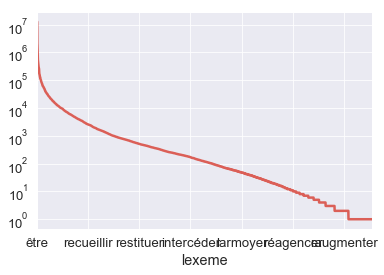

In [241]:
ax=dfV.groupby("lexeme")["occurrences"].sum().sort_values(ascending=False)[:].plot()
ax.set_yscale('log')

# Statistiques sur les cases du paradigme morphosyntaxique


## Filtrer les scories de Lexique4
- quelques formes fléchies sont notées avec des lexèmes qui ne correspondent pas à un verbe
- quelques formes ne sont pas identifiées : infover = NaN
- une forme est indiquée comme impératif 3S

Dans tous les cas, on remplace l'étiquette de Lexique.org par l'étiquette Grace

In [242]:
dfV.infover.unique()

array([u'par:pas:', u'ind:pre:3', u'ind:pas:3', u'ind:imp:3',
       u'ind:imp:1', u'ind:imp:2', u'par:pre', u'imp:pre:2', u'ind:pre:1',
       u'inf', u'ind:fut:3', u'ind:fut:1', u'cnd:pre:3', u'cnd:pre:1',
       u'cnd:pre:2', u'ind:fut:2', u'ind:pre:2', u'imp:pre:1',
       u'ind:pas:2', u'ind:pas:1', u'sub:pre:1', u'sub:pre:3',
       u'sub:pre:2', u'sub:imp:3', u'inf;', u'sub:imp:1', u'sub:imp:2',
       u'ind:pas:3s;', u'imp:pre:1p;ind:pre:1p;',
       u'imp:pre:2p;ind:pre:2p;par:pas;', u'imp:pre:3',
       u'imp:pre:2s;ind:pre:1s;ind:pre:3s;sub:pre:3s;'], dtype=object)

In [243]:
def infover2Case(lRow):
    result=""
    lInfover=lRow["infover"]
    lNombre=lRow["nombre"]
    if isinstance(lInfover,unicode):
        if lInfover in [u'imp:pre:2p;ind:pre:2p;par:pas;',
       u'imp:pre:2s;ind:pre:1s;ind:pre:3s;sub:pre:3s;',
       u'imp:pre:1p;ind:pre:1p;']:
            print lRow["graphie"],lRow["lexeme"]
        else:
            if lInfover[:3]==u"inf":
                result=u"inf"
            elif lInfover==u"par:pre":
                result="pP"
            elif lInfover[:8]==u"par:pas:":
                if lNombre in ["s","p"]:
                    lNombre=lNombre.upper()
                else:
                    print lRow
                lGenre=lRow["genre"]
                if lGenre in ["m","f"]:
                    lGenre=lGenre.upper()
                else:
                    print lRow
                result="pp"+lGenre+lNombre
            else:
                if lNombre in ["s","p"]:
                    lNombre=lNombre.upper()
                    if lInfover[:8]==u"ind:pre:":
                        result="pi"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"ind:imp:":
                        result="ii"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"ind:fut:":
                        result="fi"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"ind:pas:":
                        result="ai"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"imp:pre:":
                        result="pI"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"sub:pre:":
                        result="ps"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"sub:imp:":
                        result="is"+lInfover[8]+lNombre
                    elif  lInfover[:8]==u"cnd:pre:":
                        result="pc"+lInfover[8]+lNombre
                else:
                    print lRow               
    return result

Suite aux groupby avec des agg multiples, les DataFrames *df* ont des colonnes MultiIndex.
- df.columns est le MultiIndex
- df.columns.to_series() : on simplifie la structure des colonnes en exportant le MultiIndex sous forme d'une liste de tuples
- on fait une compréhension de la liste des tuples pour extraire la série de tuple[1] sinon tuple[0]

In [244]:
def multi2simple(lDF):
    lDF.columns=[c if c else sc for sc,c in lDF.columns.to_series().tolist()]
    lDF.reset_index(inplace=True)
    return

In [245]:
print "Problèmes de lexème"
dfV["case"]=dfV.apply(infover2Case,axis=1)
condNotInvalidCell=(dfV.case!="")&(dfV.case!="pI3S")
dfV=dfV[condNotInvalidCell]
display(dfV.head())
print len(dfV)

Problèmes de lexème
excitons exciton
faîtes faîte
monte monte
monte monte
partons parton
transposons transposon


/Users/gilles/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,graphie,lexeme,cat,infover,genre,nombre,occurrences,case
78,-tu,taire,VER,par:pas:,m,s,8.0,ppMS
116,=,égaler,VER,ind:pre:3,NaN,s,4218.0,pi3S
127,a,avoir,AUX,ind:pre:3,NaN,s,2139655.0,pi3S
128,a,avoir,VER,ind:pre:3,NaN,s,1528403.0,pi3S
129,a,avoir,VER,par:pas:,m,s,1.0,ppMS


106738


# Exportation de Lexique4-Verbes

In [246]:
dfV.to_csv(path_or_buf="Lexique4-Verbes.tsv",sep="\t",index=None,encoding="utf8")

In [247]:
# etCols=[c for et in etCells for c in et] #déplacé dans ET
dfCasesTokens=dfV.groupby(["case"])[["occurrences"]].sum().sort_values("occurrences",ascending=False)
tokenCols=dfCasesTokens.index.tolist()
dfCasesTypes=dfV.groupby(["case"])[["occurrences"]].count().sort_values("occurrences",ascending=False)
typeCols=dfCasesTypes.index.tolist()

In [248]:
exemplaireCases=set(dfV.case.unique())
nbCases=len(exemplaireCases)

In [249]:
dfVerbesNbCases=dfV[dfV.case!=""].groupby(["lexeme","case"])["occurrences"].count().groupby("lexeme").count().sort_values(ascending=False)
dfVerbesNbCases

lexeme
avoir            51
faire            50
devoir           50
mettre           49
savoir           49
être             48
prendre          48
connaître        47
venir            47
aller            47
entendre         47
voir             47
pouvoir          47
dire             47
devenir          47
donner           46
rester           46
trouver          46
envoyer          46
laisser          46
vouloir          46
croire           46
porter           45
manquer          45
aimer            45
apprendre        45
retirer          45
parler           45
passer           45
demander         45
                 ..
engainer          1
mâchurer          1
revacciner        1
mordorer          1
duplexer          1
enkyster          1
mitrer            1
dopa              1
entabler          1
enstérer          1
boyauter          1
bouturer          1
refortifier       1
boustifailler     1
doublonner        1
doucir            1
mithridatiser     1
dragonner         1
droper       

In [407]:
personnes=[p+n for n in "SP" for p in "123" ]
cases=[t+p for t in "pi ii fi pc ps ai is".split(" ") for p in personnes]
cases+="pI2S pI1P pI2P inf pP".split(" ")
cases+=["pp"+g+n for g in "MF" for n in "SP"]

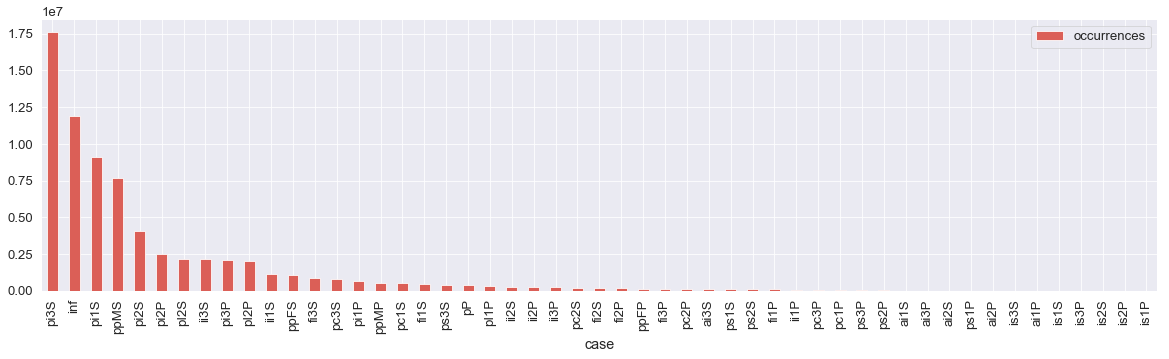

In [16]:
ax=dfCasesTokens.plot(kind="bar",figsize=(20,5))
#ax.set_yscale('log')

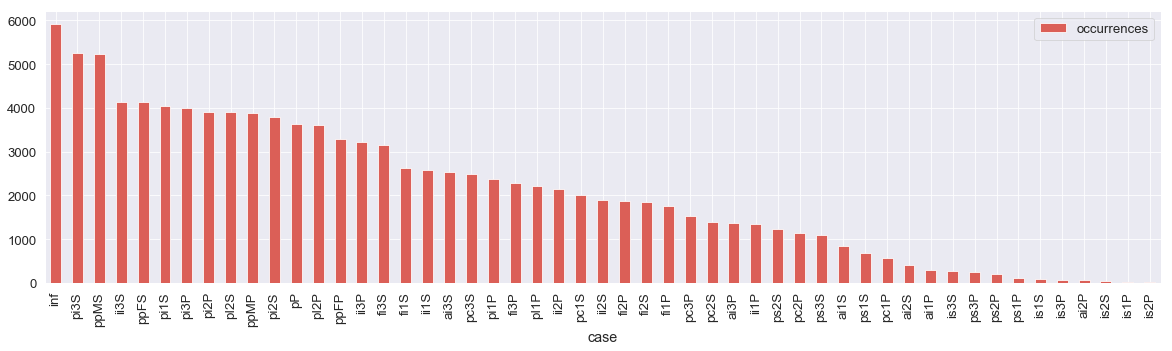

In [17]:
ax=dfCasesTypes.plot(kind="bar",figsize=(20,5))
#ax.set_yscale('log')


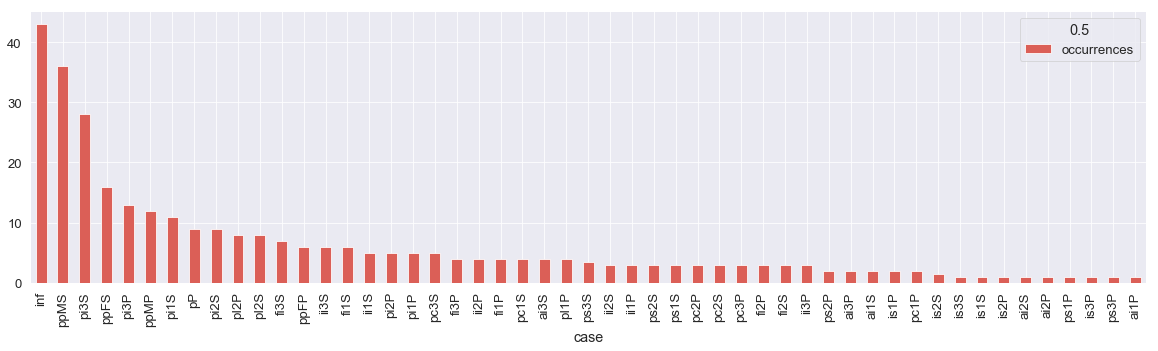

In [18]:
dfV.groupby("case")[["occurrences"]].quantile(q=0.5).sort_values("occurrences",ascending=False).plot(kind="bar",figsize=(20,5))

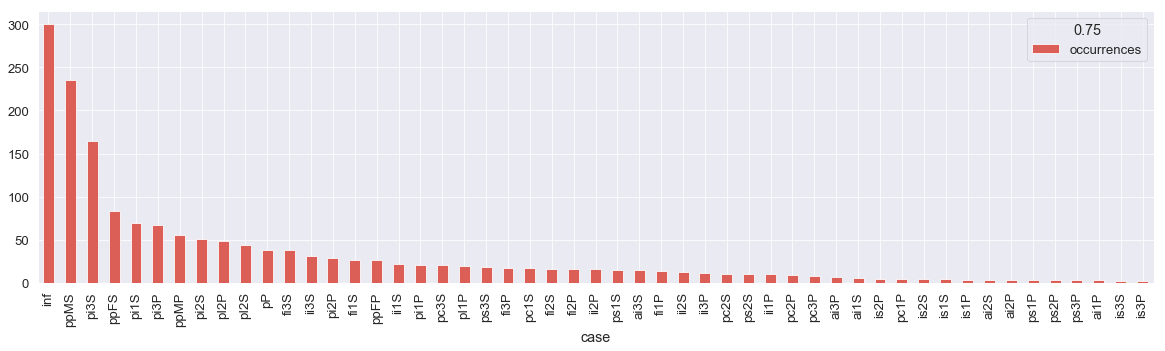

In [19]:
dfV.groupby("case")[["occurrences"]].quantile(q=0.75).sort_values("occurrences",ascending=False).plot(kind="bar",figsize=(20,5))

# Statistiques sur les lexèmes

In [20]:
dfCells=dfV[dfV.occurrences>0].groupby(["lexeme","case"]).agg({"occurrences":[("tokens","sum"),("abondance","count")],"graphie":[("graphies",", ".join)]}).reset_index()

In [21]:
multi2simple(dfCells)
dfCells

,index,lexeme,case,tokens,abondance,graphies
0,0,abaisser,ai2P,1.0,1,abaissâtes
1,1,abaisser,ai3S,5.0,1,abaissa
2,2,abaisser,fi1P,3.0,1,abaisserons
3,3,abaisser,fi1S,69.0,1,abaisserai
4,4,abaisser,fi2P,3.0,1,abaisserez
5,5,abaisser,fi2S,4.0,1,abaisseras
6,6,abaisser,fi3P,8.0,1,abaisseront
7,7,abaisser,fi3S,30.0,1,abaissera
8,8,abaisser,ii1P,1.0,1,abaissions
9,9,abaisser,ii1S,4.0,1,abaissais


In [22]:
dfCells[dfCells.abondance>1]

,index,lexeme,case,tokens,abondance,graphies
50,50,abandonner,ii3P,37.0,2,"abandonnaient, abandonné"
51,51,abandonner,ii3S,187.0,2,"abandonnait, abandonné"
54,54,abandonner,pI2P,1304.0,2,"abandonner, abandonnez"
65,65,abandonner,pi2P,755.0,2,"abandonner, abandonnez"
115,115,abattre,pi2P,75.0,2,"abattez, abattre"
264,264,aborder,ii3P,10.0,2,"abordaient, abordé"
345,345,aboyer,pi2P,16.0,2,"aboyer, aboyez"
394,394,abriter,inf,567.0,2,"abriter, abriter"
518,518,absorber,ii3P,11.0,2,"absorbaient, absorbé"
551,551,absoudre,pi2P,2.0,2,"absolvez, absoudre"


In [23]:
dfVerbes=dfCells.groupby("lexeme").agg({"tokens":[('nbCases', 'count'), ('nbTokens', 'sum')],"case":[("cases",", ".join)]})#.sort_values("occurrences",ascending=False).reset_index()
multi2simple(dfVerbes)
dfVerbes.head()

,lexeme,nbCases,nbTokens,cases
0,abaisser,34,1663.0,"ai2P, ai3S, fi1P, fi1S, fi2P, fi2S, fi3P, fi3S..."
1,abandonner,43,42772.0,"ai1P, ai1S, ai2P, ai2S, ai3P, ai3S, fi1P, fi1S..."
2,abasourdir,10,249.0,"fi1S, inf, pI2P, pi2S, pi3S, ppFP, ppFS, ppMP,..."
3,abattre,40,11857.0,"ai2S, ai3P, ai3S, fi1P, fi1S, fi2P, fi2S, fi3P..."
4,abcéder,2,2.0,"ppMP, ppMS"


In [24]:
dfDistCases=dfVerbes.groupby("cases").agg({"lexeme":[("nbLexemes","count"),("listLexemes",",".join)],"nbCases":[("nbCells","first")]})
dfDistCases.columns=[c for sc,c in dfDistCases.columns.to_series().tolist()]
dfDistCases=dfDistCases.reset_index().sort_values(["nbCells","nbLexemes"],ascending=False)

In [25]:
dfDistCases#[dfDistCases.nbLexemes>1]

,cases,nbLexemes,listLexemes,nbCells
0,"ai1P, ai1S, ai2P, ai2S, ai3P, ai3S, fi1P, fi1S...",1,avoir,51
3,"ai1P, ai1S, ai2P, ai2S, ai3P, ai3S, fi1P, fi1S...",1,faire,50
30,"ai1P, ai1S, ai2S, ai3P, ai3S, fi1P, fi1S, fi2P...",1,devoir,50
4,"ai1P, ai1S, ai2P, ai2S, ai3P, ai3S, fi1P, fi1S...",1,mettre,49
31,"ai1P, ai1S, ai2S, ai3P, ai3S, fi1P, fi1S, fi2P...",1,savoir,49
1,"ai1P, ai1S, ai2P, ai2S, ai3P, ai3S, fi1P, fi1S...",1,être,48
6,"ai1P, ai1S, ai2P, ai2S, ai3P, ai3S, fi1P, fi1S...",1,prendre,48
2,"ai1P, ai1S, ai2P, ai2S, ai3P, ai3S, fi1P, fi1S...",1,pouvoir,47
5,"ai1P, ai1S, ai2P, ai2S, ai3P, ai3S, fi1P, fi1S...",1,aller,47
8,"ai1P, ai1S, ai2P, ai2S, ai3P, ai3S, fi1P, fi1S...",1,devenir,47


## Nombre de lexèmes et de formes par lexème
- dfVerbes compte un élément par lexème
- nbCases compte le nombre de cases remplies pour chaque lexème

In [26]:
nbLexemes=len(dfVerbes)
numMedian=nbLexemes/2
print u"Nombre de lexèmes : %d"%nbLexemes
print u"Numéro du lexème médian : %d"%numMedian
print u"Nombre de formes médian par lexème : %d"%dfVerbes.nbCases.median()
print u"Nombre de formes moyen par lexème : %0.1f"%dfVerbes.nbCases.mean()

Nombre de lexèmes : 6548
Numéro du lexème médian : 3274
Nombre de formes médian par lexème : 13
Nombre de formes moyen par lexème : 15.9


Le nombre moyen de formes par lexème est légèrement supérieur à celui calculé par Bonami & Beniamine mais du même ordre de grandeur.

### Distribution du nombre de formes par lexème
- on compte le nombre de lexèmes qui ont *n* cases remplies dans Lexique4

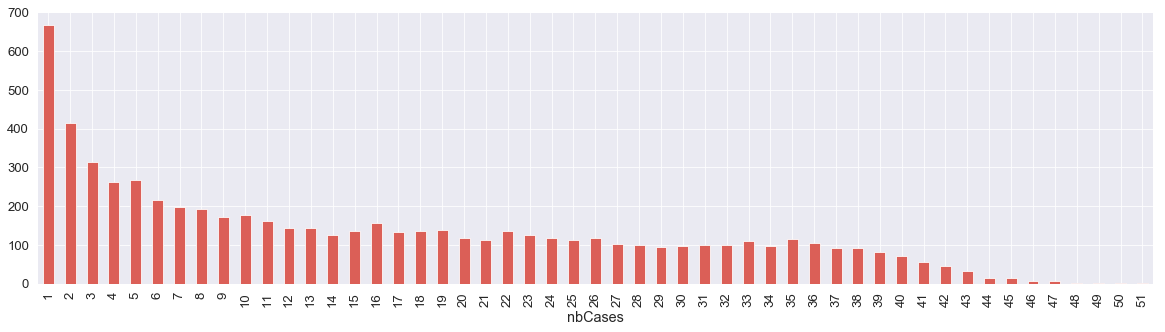

In [27]:
dfVerbesDistCases=dfVerbes.groupby("nbCases").agg({"cases":[("nbVerbes","count")],"nbTokens":[("tokens","sum")]})
dfVerbesDistCases[("cases","nbVerbes")].plot(kind='bar',figsize=(20,5))

In [28]:
lDefectifs=[u"abstraire", u"accroire", u"adirer", u"advenir", u"apparoir", u"assavoir", u"avenir", u"becter", u"béer", u"bienvenir", u"braire", u"bruire", u"chaloir", u"choir", u"clore", u"comparoir", u"contrefoutre", u"courre", u"déchoir", u"déclore", u"dépourvoir", u"discontinuer", u"dissoudre", u"distraire", u"douer", u"échoir", u"éclore", u"enclore", u"endêver", u"ensuivre", u"ester", u"extraire", u"faillir", u"férir", u"forclore", u"forfaire", u"foutre", u"frire", u"gésir", u"huir", u"impartir", u"issir", u"malfaire", u"méfaire", u"messeoir", u"moufeter", u"moufter", u"mourir", u"oindre", u"ouïr", u"paître", u"parfaire", u"poindre", u"quérir", u"raire", u"rassir", u"ravoir", u"reclure", u"revaloir", u"saillir", u"seoir", u"sourdre", u"soustraire", u"stupéfaire", u"surfaire", u"titre", u"traire", u"urger"]
dfVerbes[dfVerbes.lexeme.isin(lDefectifs)]

,lexeme,nbCases,nbTokens,cases
29,abstraire,6,121.0,"inf, pi3S, ppFP, ppFS, ppMP, ppMS"
59,accroire,1,64.0,inf
109,advenir,16,1503.0,"ai3S, fi3P, fi3S, ii3S, inf, pP, pc3P, pc3S, p..."
460,avenir,1,72.0,inf
552,becter,8,32.0,"inf, pP, pi1S, pi3P, pi3S, ppFP, ppFS, ppMS"
686,braire,2,43.0,"inf, pi3S"
736,bruire,2,85.0,"inf, pi3S"
923,chaloir,1,18.0,inf
992,choir,14,845.0,"ai1S, ai3S, fi1S, fi2P, inf, is3S, pI2S, pi1S,..."
1075,clore,16,2704.0,"fi1P, fi3P, fi3S, inf, pI2S, pc3S, pi1S, pi3P,..."


# Vecteurs de distribution des formes

## Vecteurs de distribution des tokens entre formes

Ajouter de la couleur dans les tables Pandas


In [29]:
cmap = cmap=sns.diverging_palette(0, 250,n=10, as_cmap=True)

from IPython.display import HTML

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "4pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]


In [30]:
dfParTokens=dfV.pivot_table(index=["lexeme"],values="occurrences",columns=["case"]).reset_index()
dfParTokens=dfParTokens[["lexeme"]+etCols]
dfParTokens

case,lexeme,ii1S,ii2S,ii3S,ii1P,ii2P,ii3P,pi1P,pi2P,pi3P,...,is1S,is2S,is3S,is1P,is2P,is3P,ppMS,ppMP,ppFS,ppFP
0,abaisser,4.0,3.0,6.0,1.0,2.0,3.0,7.0,21.00,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,122.0,17.0,40.0,9.0
1,abandonner,99.0,34.0,93.5,31.0,92.0,18.5,193.0,377.50,661.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9855.0,1127.0,2533.0,604.0
2,abasourdir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,155.0,30.0,47.0,2.0
3,abattre,10.0,5.0,52.0,6.0,23.0,28.0,12.0,37.50,188.0,...,NaN,NaN,1.0,NaN,NaN,NaN,3702.0,612.0,541.0,76.0
4,abcéder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
5,abdiquer,NaN,NaN,1.0,1.0,1.0,1.0,1.0,8.00,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1.0,NaN,NaN
6,aberrer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
7,abhorrer,1.0,NaN,4.0,NaN,1.0,1.0,2.0,4.00,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN
8,abjurer,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,1.0,1.0
9,abolir,NaN,NaN,1.0,1.0,NaN,NaN,4.0,3.00,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,138.0,10.0,65.0,12.0


In [31]:
dfParTokens[dfParTokens.lexeme.isin(lDefectifs)][["lexeme"]+etCols].style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '1pt'})\
    .set_caption("Hover to magnify")\
    .set_table_styles(magnify())

/Users/gilles/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


#### Déclaration d'un style pour une table
les informations de style sont stockées dans une liste. Chaque élément est déclaré avec un dict qui contient le sélecteur d'un côté et les propriétés de l'autre.

In [38]:
styles = [
    dict(selector="thead th", props=[("text-align", "center")]),
    dict(selector="tbody td.col0", props=[("background-color", "AntiqueWhite"),("text-align", "right")]),
#     dict(selector="thead th.col1", props=[("background-color", "AntiqueWhite")]),
    dict(selector="thead th.col1", props=[("background-color", "#ff8000")]),
    dict(selector="thead th.col2", props=[("background-color", "#ff8000")]),
    dict(selector="thead th.col3", props=[("background-color", "#ff8000")]),
    dict(selector="thead th.col4", props=[("background-color", "#ff8000")]),
    dict(selector="thead th.col5", props=[("background-color", "#ff8000")]),
    dict(selector="thead th.col6", props=[("background-color", "#ff8000")]),
    dict(selector="thead th.col7", props=[("background-color", "#ff8000")]),
    dict(selector="thead th.col8", props=[("background-color", "#ff8000")]),
    dict(selector="thead th.col9", props=[("background-color", "#dfbf9f")]),
    dict(selector="thead th.col10", props=[("background-color", "#bf8040")]),
    dict(selector="thead th.col11", props=[("background-color", "#bf8040")]),
    dict(selector="thead th.col12", props=[("background-color", "#bf8040")]),
    dict(selector="thead th.col13", props=[("background-color", "#e5e5ff")]),
    dict(selector="thead th.col14", props=[("background-color", "#ffff80")]),
    dict(selector="thead th.col15", props=[("background-color", "#bfbfff")]),
    dict(selector="thead th.col16", props=[("background-color", "#bfbfff")]),
    dict(selector="thead th.col17", props=[("background-color", "#80bfbf")]),
    dict(selector="thead th.col18", props=[("background-color", "#80bfbf")]),
    dict(selector="thead th.col19", props=[("background-color", "#80bfbf")]),
    dict(selector="thead th.col20", props=[("background-color", "#80bfbf")]),
    dict(selector="thead th.col21", props=[("background-color", "#8080ff")]),
    dict(selector="thead th.col22", props=[("background-color", "#8080ff")]),
    dict(selector="thead th.col23", props=[("background-color", "#80ffff")]),
    dict(selector="thead th.col24", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col25", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col26", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col27", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col28", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col29", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col30", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col31", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col32", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col33", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col34", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col35", props=[("background-color", "#bfff00")]),
    dict(selector="thead th.col36", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col37", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col38", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col39", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col40", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col41", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col42", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col43", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col44", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col45", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col46", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col47", props=[("background-color", "#ffbfbf")]),
    dict(selector="thead th.col48", props=[("background-color", "#ff80ff")]),
    dict(selector="thead th.col49", props=[("background-color", "#ff80ff")]),
    dict(selector="thead th.col50", props=[("background-color", "#ff80ff")]),
    dict(selector="thead th.col51", props=[("background-color", "#ff80ff")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

#### Correspondance des couleurs avec les cases de l'espace thématique

#### Formatage des cellules d'après leur valeur
- si la cellule contient une chaîne unicode, on ne fait rien
- si la cellule est un NaN, on met le texte en blanc sur fond blanc
- si la cellule a une valeur numérique
    - LightCoral pour les valeurs jusqu'à 5
    - Chartreuse pour les valeurs à partir de 100

In [43]:
def _color_red_or_green(val):
    result=""
    if isinstance(val,unicode):
        color="white"
    elif pd.isna(val):
        result="color:white"
    else:
        if val<=5:
            result='background-color:LightCoral'
        elif val>=100:
            result = 'background-color:Chartreuse'
    return result

In [44]:
dfParTokens[dfParTokens.lexeme.isin(lDefectifs)].style.set_table_styles(styles).applymap(_color_red_or_green)

In [35]:
pyperclip.copy(makeTabularParadigmeDF("dire",dfParTokens,dictEtColours,title="",coulLim=False, cat="V",dictMorphomes={},ipa=False))

# TEMP

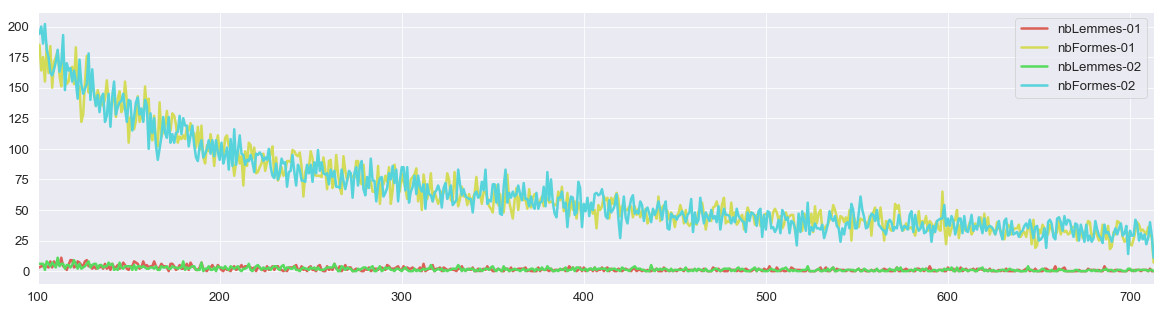

In [105]:
df1=pd.read_pickle("Tokens-LemmesFormes-01.pkl")
df2=pd.read_pickle("Tokens-LemmesFormes-02.pkl")
# df1.join(df2,lsuffix="-01",rsuffix="-02").iloc[500:].diff(periods=1).plot()
df1.join(df2,lsuffix="-01",rsuffix="-02").iloc[100:].diff().plot(figsize=(20,5))